### Introduction

When studying biophysical processes sometimes there is need to validate theoretical simulations by comparing them with empirical available data. This gives support to the interpretations and hypothesis derived from the theoretical method and is a vital part when using simulations as computational experiments.

Free energy is a key thermodynamic property of physical system because it can predict the spontaneity of a physical change. In this tutorial we evaluate the free energy of folding for a specific protein system. We again rely in the Weighted Histogram Analysis Method [(WHAM)](https://onlinelibrary.wiley.com/doi/abs/10.1002/jcc.540130812) to project the free energy into the fraction of native contacts as reaction coordinate.

### Requirements 

- [OpenMM python API](http://openmm.org/)
- [sbmOpenMM library](https://bitbucket.org/compbiochbiophlab/sbm-openmm/src)
- [MDTraj library](http://mdtraj.org/)
- [Numpy](https://numpy.org/)
- [Matplotlib](https://matplotlib.org/)
- [PyWham](http://pywham.net/)
- [SciPy](https://www.scipy.org/)

### Running several simulations  at the folding temperature using the CA model

In order to study the folding process we are going to focus our sampling at the folding temperature. This simulations should explore the folded and unfolded configurations with equal probability, so they will sample the transition several times. If the folding process is complex enough we should be able to observe intermediaries along the reaction coordinate selected.

We load OpenMM and the sbmOpenMM library:

In [1]:
#Import OpenMM library
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *

#Import sbmOpenMM library
import sbmOpenMM

We use the input pdb and the contact file for our system to create the SBM CA model object:

In [2]:
#Set the input locations as variables.
pdb_file = 'inputs/1YPA_I.pdb'
contact_file = 'inputs/1YPA_I_CA.contacts'

#Create an sbmOpenMM.system() object and store it in "sbmCAModelModel" variable. 
sbmCAModel = sbmOpenMM.models.getCAModel(pdb_file, contact_file)

Generating CA SBM for PDB file inputs/1YPA_I.pdb

Setting up geometrical parameters:
_________________________________
Keeping only carbon alpha atoms in topology
Added 64 CA atoms
Added 63 bonds
Added 62 angles
Added 61 torsions
Reading contacts from contact file: inputs/1YPA_I_CA.contacts
Added 164 native contacts

Setting up default forcefield parameters:
________________________________________
Adding default bond parameters:
Adding default angle parameters:
Adding default torsion parameters:
Adding default contact parameters:

Adding Forces:
_____________
Added Harmonic Bond Forces
Added Harmonic Angle Forces
Added Periodic Torsion Forces
Added Lennard Jones 12-10 Forces to native contacts
Added Lennard Jones 12 non-bonded Forces

Creating System Object:
______________________
The Potential Energy of the system is : -160.6621551513672 kJ/mol
The Harmonic Bond Energy is: 1.4299672557172016e-09 kj/mol
The Harmonic Angle Energy is: 3.439026841078885e-11 kj/mol
The Periodic Torsion En

We are going to run 10 replicas during 10 nanosecond each, totaling 100 nanosecond simulation for our system. This will take a while so it is recommended to use a GPU for carrying out the calculations. This sampling is far from enough for a real case scenario and is recommended the use of parallel computer to this end. For our learning purposes 100 ns should be enough.

The folding temperature for the system in the CA model was previously determined to be 136 RTU. We use this temperature for all the simulations. 

In [3]:
import time

#Set temperature to folding temperature
temperature = 136

#Define a loop with the number of replicas we wish to run.
for replica in range(10):
    
    #Define the name of the energy file for each replica
    energy_file = 'energy_'+str(replica+1).zfill(2)+'.data'
    
    #Define the name of the trajectory file for each replica
    trajectory_file = 'traj_'+str(replica+1).zfill(2)+'.dcd'
    
    #Define the integrator and context for the simulation at the defined temperature
    integrator = LangevinIntegrator(temperature, 1/picosecond, 0.5*femtoseconds)
    simulation = Simulation(sbmCAModel.topology, sbmCAModel.system, integrator)
    
    #Set the initial coordinates
    simulation.context.setPositions(sbmCAModel.positions)
    
    #Add a SBM reporter that writes energies every 1 picosecond = 2000 steps (at 0.5 fs timestep).
    simulation.reporters.append(sbmOpenMM.sbmReporter(energy_file, 2000, sbmObject=sbmCAModel,
                                                  step=True, potentialEnergy=True, temperature=True))
    
    #Add a DCD reporter that writes coordinates every 1 picosecond = 2000 steps (at 0.5 fs timestep).
    simulation.reporters.append(DCDReporter(trajectory_file, 2000))
    
    #Run each simulation for 10 ns = 20 million steps.
    start_time = time.time()
    simulation.step(20000000)
    
    print("--- Finished simulation for replica %s in %s seconds ---" % (replica+1, (time.time() - start_time)))

--- Finished simulation for replica 1 in 345.5560827255249 seconds ---
--- Finished simulation for replica 2 in 341.5513241291046 seconds ---
--- Finished simulation for replica 3 in 342.20426511764526 seconds ---
--- Finished simulation for replica 4 in 342.49917697906494 seconds ---
--- Finished simulation for replica 5 in 342.5238676071167 seconds ---
--- Finished simulation for replica 6 in 342.48812985420227 seconds ---
--- Finished simulation for replica 7 in 342.62691259384155 seconds ---
--- Finished simulation for replica 8 in 341.7369840145111 seconds ---
--- Finished simulation for replica 9 in 343.0223186016083 seconds ---
--- Finished simulation for replica 10 in 341.7025091648102 seconds ---


In order to visualize the path of our simulations we are going to calculate the root mean squared deviation (RMSD) of the simulations with reference to the input structure. Using mdtraj we load the input configuration together with the trajectory file and calculate the RMSD. We plot it with matplotlib:

In [4]:
import mdtraj as md
import matplotlib.pyplot as plt

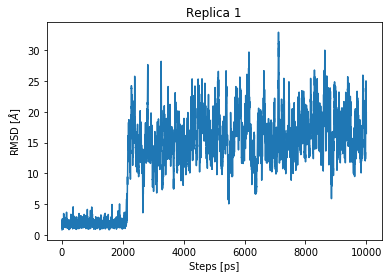

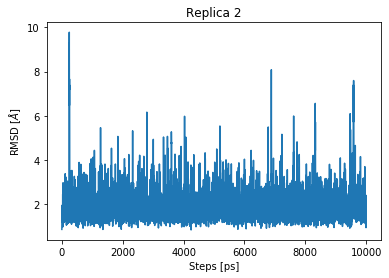

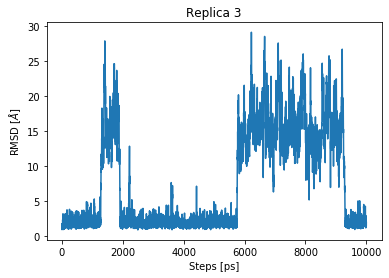

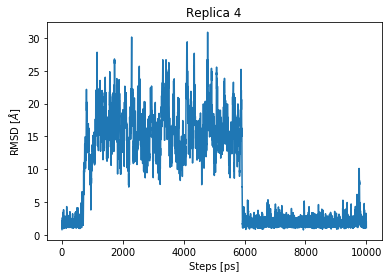

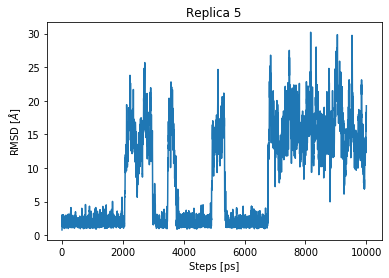

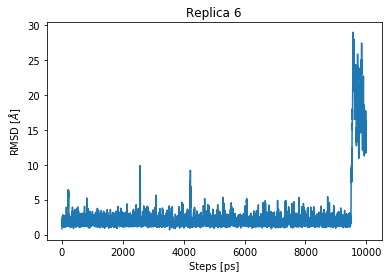

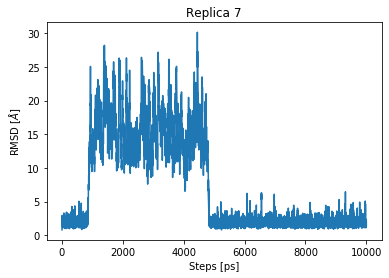

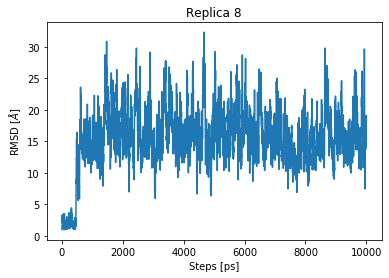

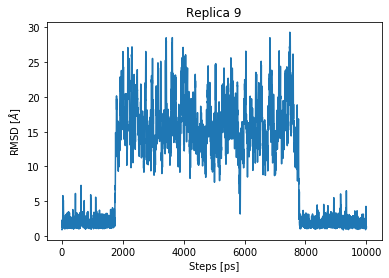

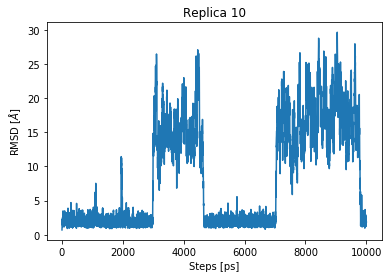

In [5]:
#We dump a pdb file for loading it as the toplogy for the trajectories
sbmCAModel.dumpPdb('input.pdb')

#Load input.pdb as the reference structure
reference = md.load('input.pdb')

#We loop over the replicas.
for replica in range(10):
    
    #Define the name of the trajectory file for each replica
    trajectory_file = 'traj_'+str(replica+1).zfill(2)+'.dcd'
    
    #Load input.pdb as the toplogy and traj.dcd as the trajectory file
    trajectory = md.load(trajectory_file, top='input.pdb')
    
    #Calculate the rmsd
    rmsd = md.rmsd(trajectory, reference)*10 #Convert from nm to angstroms

    #Plot the RMSD in a new plot for each replica
    plt.figure()
    plt.plot(rmsd)
    plt.title('Replica '+str(replica+1))
    plt.xlabel('Steps [ps]')
    plt.ylabel('RMSD [$\AA$]')

The simulations alternate between high and low RMSD configurations. It is expected that this configurations pertain to the unfolded and folded state respectively. To review this idea we are going to plot now the fraction of native contacts ($Q_f$) for each simulation.

### Calculating the fraction of native contacts $Q_f$

There are several ways to calculate $Q_f$. We are first going to use a very simple form which considers a discrete classification regarding that the contact distance is lower or equal than the defined equilibrium contact distance. It is important to note that the definition used to calculate $Q_f$ will affect how the plots will look like.

First we need to gather the list of native contacts present in our model. For this we look our SBM model object. The attribute sbmCAModel.contacts is a dictionary containing the parameters for the native contact forces. The keys of the dictionary are 2-tuples containing the pair of atoms involved in the interaction, with each atom represented as an instance of the OpenMM [simtk.openmm.app.topology.Atom class](https://simtk.org/api_docs/openmm/api6_0/python/classsimtk_1_1openmm_1_1app_1_1topology_1_1Atom.html). The values of the dictionary entries are tuples containing the parameters of the native contact bond force; the first element in the tuple represents the equilibrium distance for the contact [(OpenMM quantity object)](http://docs.openmm.org/7.1.0/api-python/generated/simtk.unit.quantity.Quantity.html) and the second value the energy of the interaction (float object). Specifically, in the default CA model, the native contact force is a 12-10 LJ potential, defined as:
<h3><center>$E_{LJ}^{12/10}= \epsilon (5(\frac{\sigma}{r})^{12}-6(\frac{\sigma}{r})^{10})$</center></h3>

Thus, the first parameter in the tuple corresponds to $\sigma$ and the second to $\epsilon$ in the above equation.

We are going to use mdtraj to calculate the native contact distances throughout the simulations. For this we will need the indexes of the atoms involved in the native interactions. Each 2-tuple, representing the keys in the sbmCAModel.contacts dictionary, contains the pair of atoms involved in each native interaction as simtk.openmm.app.topology.Atom class instances. We can get the the zero-based index of the atom objects by their "index" attribute. We use a list comprehension syntax to store those values:

In [6]:
#Get the indexes of the native contacts as a list
contacts = [(c[0].index, c[1].index) for c in sbmCAModel.contacts.keys()]
print(contacts)

[(0, 62), (0, 23), (0, 43), (0, 41), (1, 22), (1, 23), (1, 62), (1, 5), (1, 6), (1, 18), (2, 62), (2, 60), (2, 61), (2, 41), (3, 60), (3, 61), (3, 59), (4, 59), (4, 60), (4, 8), (4, 18), (4, 19), (4, 22), (4, 23), (4, 46), (4, 61), (4, 62), (5, 59), (6, 10), (6, 18), (6, 22), (7, 60), (7, 15), (7, 56), (7, 58), (7, 18), (7, 14), (7, 19), (8, 60), (8, 56), (8, 58), (8, 57), (8, 59), (9, 56), (9, 55), (10, 56), (10, 15), (10, 50), (10, 54), (10, 55), (10, 14), (11, 55), (11, 54), (11, 15), (11, 56), (12, 54), (12, 48), (12, 56), (12, 16), (12, 30), (12, 50), (12, 55), (13, 17), (14, 18), (15, 19), (15, 48), (15, 56), (15, 60), (16, 48), (16, 28), (16, 20), (16, 30), (17, 21), (18, 22), (19, 23), (19, 26), (19, 28), (19, 46), (19, 48), (19, 60), (20, 28), (20, 24), (20, 26), (23, 28), (23, 46), (23, 62), (23, 27), (23, 44), (23, 45), (23, 43), (25, 44), (26, 44), (26, 45), (26, 46), (27, 44), (27, 45), (27, 46), (27, 42), (28, 46), (28, 48), (29, 45), (29, 46), (29, 47), (29, 48), (29, 42

let's now calculate the reference distances using md traj:

In [7]:
#Load input.pdb as the reference structure
reference = md.load('input.pdb')

#Compute the referenece distances
ref_distances = md.compute_distances(reference, contacts) #Note that mdtraj uses nanometers as distance units

Now we are ready to iterate the simulations to calculate the fraction of native contacts in each simulation frame. We will need to know how many distances will be equal or below the reference equilibrium distances. For this we employ numpy's function [where](https://docs.scipy.org/doc/numpy/reference/generated/numpy.where.html) returning one when the condition is True and 0 otherwise

In [8]:
import numpy as np

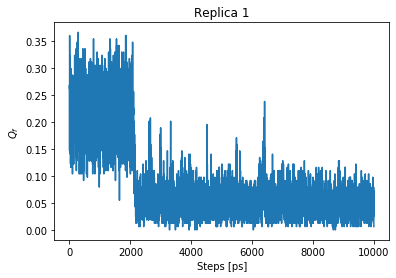

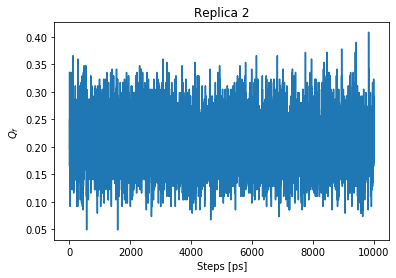

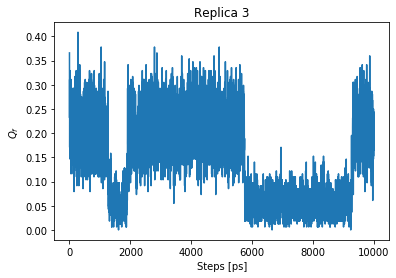

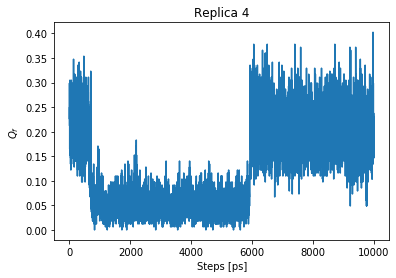

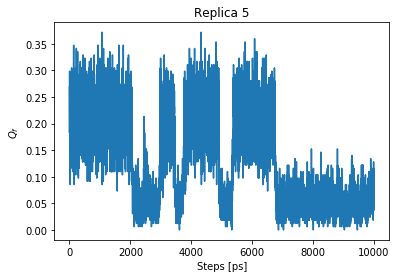

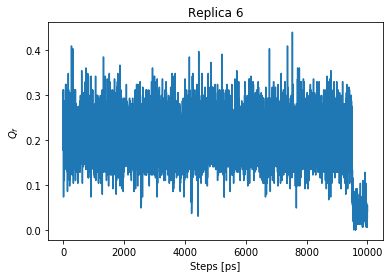

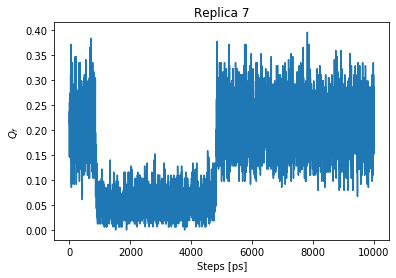

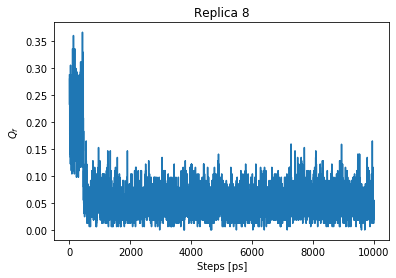

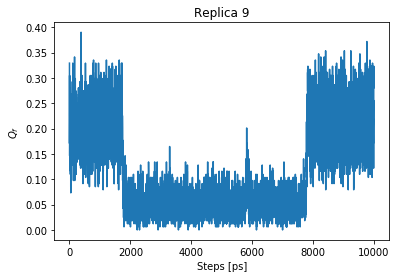

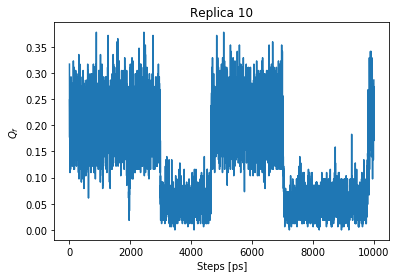

In [9]:
#We loop over the replicas.
for replica in range(10):
    
    #Define the name of the trajectory file for each replica
    trajectory_file = 'traj_'+str(replica+1).zfill(2)+'.dcd'
    
    #Load input.pdb as the toplogy and traj.dcd as the trajectory file
    trajectory = md.load(trajectory_file, top='input.pdb')
    
    #Calculate the native contact distances
    sim_distances = md.compute_distances(trajectory, contacts)
    
    #Evaluate if contacts are formed or not in each simulation frame
    formed_native_contacts = np.where(sim_distances <= ref_distances, 1, 0)
    
    #Calculate the number of formed contacts in each frame
    n_native_contacts = np.sum(formed_native_contacts, axis=1) #Note we use axis=1 to evaluate the sum only contact wise.
    
    #Calculate the fraction of native contacts formed
    Qf = n_native_contacts/len(contacts)    
    
    #Plot Qf in a new plot for each replica
    plt.figure()
    plt.plot(Qf)
    plt.title('Replica '+str(replica+1))
    plt.xlabel('Steps [ps]')
    plt.ylabel('$Q_f$')

We observe that the values of $Q_f$ explored by the simulation are low for considering them completely folded states. This raises the question of whether the simulation explores or not folded configurations. We can look again at the RMSD plots to see that the values in the suspected folded states are around 2 $\mathring A$,
which is consistent with being in near-native configurations. We can thus suspect the native contact function for 
giving exceedingly low $Q_f$ values when analyzing the simulations. To fix this we build a more permissive contact function by accepting an error in the estimation of the native contacts. This gives higher values in the estimation of the fraction of native contacts, more consistent with the definition of the folded state:

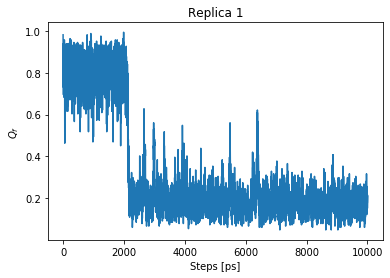

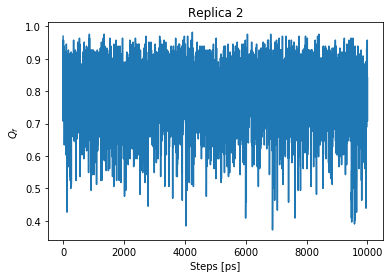

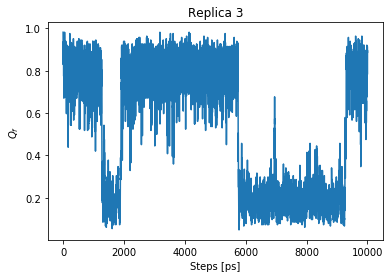

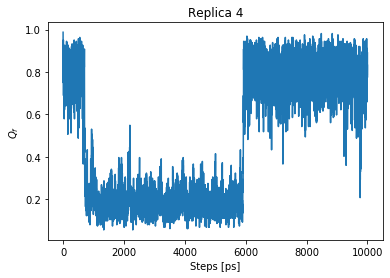

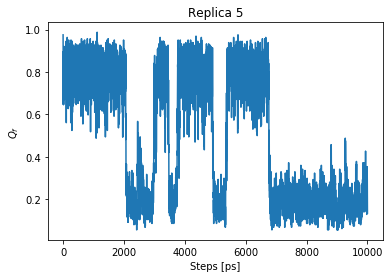

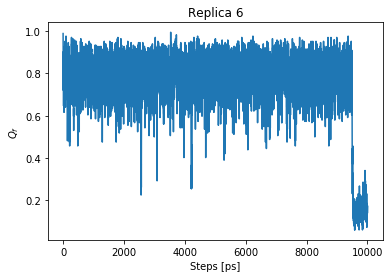

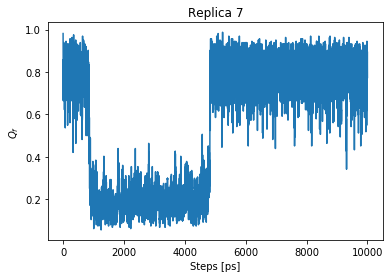

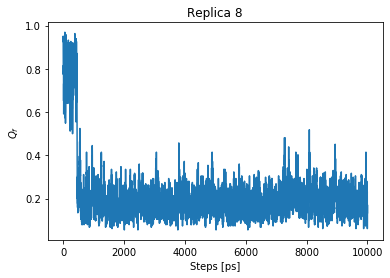

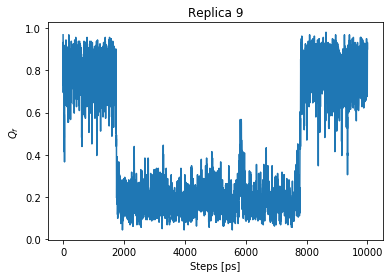

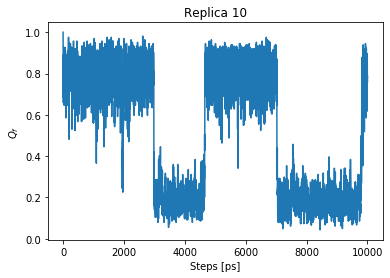

In [10]:
#Define a 20% error for the calculation of the native contacts.
error = 1.20

#We loop over the replicas.
for replica in range(10):
    
    #Define the name of the trajectory file for each replica
    trajectory_file = 'traj_'+str(replica+1).zfill(2)+'.dcd'
    
    #Load input.pdb as the toplogy and traj.dcd as the trajectory file
    trajectory = md.load(trajectory_file, top='input.pdb')
    
    #Calculate the native contact distances
    sim_distances = md.compute_distances(trajectory, contacts)
    
    #Evaluate if contacts are formed or not in each simulation frame
    formed_native_contacts = np.where(sim_distances <= ref_distances*error, 1, 0) #Note the introduction of the error variable to increase the reference distances.
    
    #Calculate the number of formed contacts in each frame
    n_native_contacts = np.sum(formed_native_contacts, axis=1) #Note we use axis=1 to evaluate the sum only contact wise and not frame wise (which would be wrong).
    
    #Calculate the fraction of native contacts formed
    Qf = n_native_contacts/len(contacts)    
    
    #Plot Qf in a new plot for each replica
    plt.figure()
    plt.plot(Qf)
    plt.title('Replica '+str(replica+1))
    plt.xlabel('Steps [ps]')
    plt.ylabel('$Q_f$')

Notice that the introduction of a 20% error gave $Q_f$ values closer to 1, which are closer to the definition of folded configurations.

### Estimating free energy profiles from the simulation data

Now that we have calculated the fraction of native contacts $Q_f$ for each simulation, we are going to estimate free energy profiles projected onto this reaction coordinate. For this we will employ PyWham, that we introduce in the [calculating folding temperature](https://mon.uvic.cat/cbbl/research/software/sbmopenmm/tutorials/03-estimating-the-folding-temperature/) tutorial. In the input folder there is a xml file, input for pywham, to calculate the free energy job. First, we write the input files for PyWham, which are two column data files containing the $Q_f$ and potential energy $V$ values.

As in previous tutorials we employ a function to read the energy files:

In [11]:
def readOpenMMReporterFile(reporter_file):
    #Open the reporter file
    with open(reporter_file, 'r') as ef:
        #Store the lines 
        lines = ef.readlines()
        #Define a dictionary to store the data
        data = {}
        #read the header and create for each term an entry for the dictionary initialised to a list
        for r in lines[0].split(','):
            data[r.replace('#','').replace('"','').strip()] = []
        #read each value in the file and store it in the dictionary's lists.
        for i,r in enumerate(data):
            for line in lines[1:]:
                #Convert the read string into a float for easy processing of numerical data
                data[r].append(float(line.strip().split(',')[i]))
                
        #Convert each list into a numpy array
        for entry in data:
            data[entry] = np.array(data[entry])
            
    #return the created dictionary
    return data

Gather the data for each simulation and write it down to a file:

In [12]:
#Create a list to store the paths of the output files
output_files = []

#Create the output folder if it does not exists
folderName = 'simulationData'
if not os.path.exists(folderName):
    os.mkdir(folderName)

#We loop over the replicas.
for replica in range(10):
    
        ## Calculate the fraction of native contacts ##
    
    #Define the name of the trajectory file for each replica
    trajectory_file = 'traj_'+str(replica+1).zfill(2)+'.dcd'
    
    #Load input.pdb as the toplogy and traj.dcd as the trajectory file
    trajectory = md.load(trajectory_file, top='input.pdb')
    
    #Calculate the native contact distances
    sim_distances = md.compute_distances(trajectory, contacts)
    
    #Evaluate if contacts are formed or not in each simulation frame
    formed_native_contacts = np.where(sim_distances <= ref_distances*error, 1, 0) #Note the introduction of the error variable to increase the reference distances.
    
    #Calculate the number of formed contacts in each frame
    n_native_contacts = np.sum(formed_native_contacts, axis=1) #Note we use axis=1 to evaluate the sum only contact wise and not frame wise (which would be wrong).
    
    #Calculate the fraction of native contacts formed
    Qf = n_native_contacts/len(contacts) 
    
        ## Retrieve the potential energy values ##
    
    #Define the name of the energy file for each replica
    energy_file = 'energy_'+str(replica+1).zfill(2)+'.data'
    
    #Read the energy data from each energy file
    simulationData = readOpenMMReporterFile(energy_file)
    
    #For easy reading we store the potential energy numpy array into a variable
    V = simulationData['Potential Energy (kJ/mole)']
    
        ## Write simulation data to file ##
    
    #Define the path name of the outputfile
    fileName = folderName+'/Qf_'+str(replica).zfill(2)+'.data'
    
    #Write data as columns into the output file
    with open(fileName, 'w') as wf:
        for i in range(trajectory.n_frames):
            wf.write('%f %f \n' % (Qf[i],V[i]))
    
    #Append the output file name to the output_files list
    output_files.append(fileName)

We now run PyWham using the input xml script 'pywham_Qf_free_energy.xml' found in the 'inputs' folder. The output file generated is called 'pywham_Qf_free_energy_T136.0', with T136.0 reflecting the temperature at which we calculated the free energy values. We can read the vaues in this file to make the free energy vs $Q_f$ plot:

(0, 1)

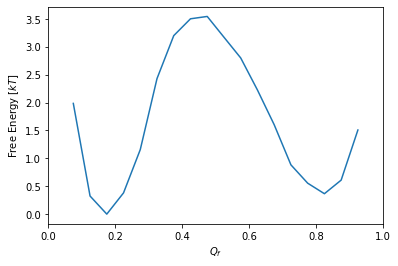

In [13]:
#Create lists to store the calculated values.
Qf = []
free_energy = []

#Read the PyWham free energy output file
with open('pywham_Qf_free_energy_T136.0', 'r') as hcf:
    #Iterate over the lines and store the values
    for line in hcf:
        ls = line.strip().split()
        Qf.append(float(ls[0]))
        free_energy.append(float(ls[1]))

#Convert list to numpy arrays for easy computation
free_energy = np.array(free_energy)
Qf = np.array(Qf)

#Set the lower minimum of the free energy profile to zero
free_energy = free_energy- np.min(free_energy)

#Plot the free energy projected into the fraction of native contacts
plt.plot(Qf, free_energy)
plt.xlabel('$Q_f$')
plt.ylabel('Free Energy [$kT$]')
plt.xlim(0,1)

We observe that the plot shows two minima with a free energy barrier of around 3.5 $kT$ at the folding temperature. The two states correspond to the unfolded (low $Q_f$) and the folded configurations (high $Q_f$). 

For now our plot is a bit rough, probably because of sampling convergence and the bin width selected for the WHAM calculation with PyWham (intervals of 0.05 at $Q_f$, see the input file 'pywham_Qf_free_energy.xml'). We can, optionally, improve its looks by interpolating values with the aid of the interpolate module in Scipy:

In [14]:
from scipy import interpolate

(0, 1)

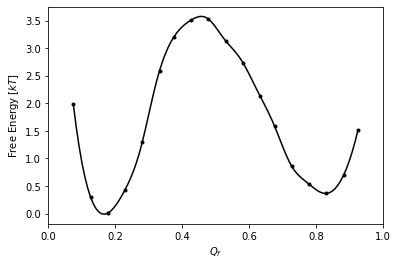

In [15]:
#Define a B-spline function to interpolate the input function.
Bspline = interpolate.splrep(Qf, free_energy)

#Define a hundred new points of data over we wish to interpolate
Qf_newpoints = np.linspace(Qf.min(), Qf.max(), 100)

#Interpolate the values of free energy 
free_energy_interpolated = np.array([interpolate.splev(x, Bspline) for x in Qf_newpoints])

#Define marks to see where our original points layed in the new interpolated function
marks = list(np.searchsorted(Qf_newpoints, Qf))

#Plot the interpolated function marking the original data points
plt.plot(Qf_newpoints, free_energy_interpolated, 'k-o', markersize=3, markevery=marks)
plt.xlabel('$Q_f$')
plt.ylabel('Free Energy [$kT$]')
plt.xlim(0,1)

The interpolated free energy function depicts the same information as before but it has a better look now that we have interpolated the data with a spline function. It is important to make the reminder here of the fact that our simulation is too short for research purposes and increasing simulation time is needed to extract meaningful conclusions of the data.

As an exercise, we are going to make a similar plot that considers RMSD as the folding coordinate. We repeat the process above to store the simulation data for PyWham using now as the first coordinate the RMSD function:

In [17]:
#Create a list to store the paths of the output files
output_files = []

#Create the output folder if it does not exists
folderName = 'simulationData'
if not os.path.exists(folderName):
    os.mkdir(folderName)

#We loop over the replicas.
for replica in range(10):
    
        ## Calculate the RMSD  ##
    
    #Define the name of the trajectory file for each replica
    trajectory_file = 'traj_'+str(replica+1).zfill(2)+'.dcd'
    
    #Load input.pdb as the toplogy and traj.dcd as the trajectory file
    trajectory = md.load(trajectory_file, top='input.pdb')
    
    #Calculate the native contact distances
    sim_distances = md.compute_distances(trajectory, contacts)
    
    #Evaluate if contacts are formed or not in each simulation frame
    formed_native_contacts = np.where(sim_distances <= ref_distances*error, 1, 0) #Note the introduction of the error variable to increase the reference distances.
    
    #Calculate the number of formed contacts in each frame
    n_native_contacts = np.sum(formed_native_contacts, axis=1) #Note we use axis=1 to evaluate the sum only contact wise and not frame wise (which would be wrong).
    
    #Calculate the fraction of native contacts formed
    Qf = n_native_contacts/len(contacts) 
    
        ## Retrieve the potential energy values ##
    
    #Define the name of the energy file for each replica
    energy_file = 'energy_'+str(replica+1).zfill(2)+'.data'
    
    #Read the energy data from each energy file
    simulationData = readOpenMMReporterFile(energy_file)
    
    #For easy reading we store the potential energy numpy array into a variable
    V = simulationData['Potential Energy (kJ/mole)']
    
        ## Write simulation data to file ##
    
    #Define the path name of the outputfile
    fileName = folderName+'/RMSD_'+str(replica).zfill(2)+'.data'
    
    #Write data as columns into the output file
    with open(fileName, 'w') as wf:
        for i in range(trajectory.n_frames):
            wf.write('%f %f \n' % (Qf[i],V[i]))
    
    #Append the output file name to the output_files list
    output_files.append(fileName)

We use the written files to calculate the free energy profile with PyWham using as input the 'pywham_RMSD_free_energy.xml' file located in the inputs file. The output file generated has the name 'pywham_RMSD_free_energy_T136.0', we read it to plot the free energy values projected along the RMSD of the sampled configurations:

Text(0, 0.5, 'Free Energy [$kT$]')

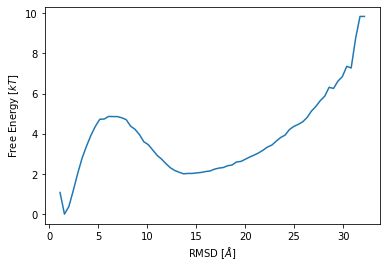

In [18]:
#Create lists to store the calculated values.
RMSD = []
free_energy = []

#Read the PyWham free energy output file
with open('pywham_RMSD_free_energy_T136.0', 'r') as hcf:
    #Iterate over the lines and store the values
    for line in hcf:
        ls = line.strip().split()
        RMSD.append(float(ls[0]))
        free_energy.append(float(ls[1]))

#Convert list to numpy arrays for easy computation
free_energy = np.array(free_energy)
RMSD = np.array(RMSD)

#Set the lower minimum of the free energy profile to zero
free_energy = free_energy- np.min(free_energy)

#Plot the free energy projected into the fraction of native contacts
plt.plot(RMSD, free_energy)
plt.xlabel('RMSD [$\AA$]')
plt.ylabel('Free Energy [$kT$]')

We again observe two minima, although we have now a very different shape for the profile; the folded minimum appears very localized at the left of the plot and the unfolded one is dispersed through a large range of RMSD values. The unfolding free energy barrier now has increased in approximately 1.5 $kT$.

We can see now the important effect that the selection of reaction coordinate has over the free energy profile of a particular simulation study. Sometimes, however, having several reaction coordinates can help us to extract different information from our simulations.

As a last exercise we plot the free energy profile projected into a bi-dimensional reaction coordinate. First, we write the data to use as input of PyWham for this calculation. This data consists of three columns: Qf, RMSD and V (the potential energy).

In [19]:
#Create a list to store the paths of the output files
output_files = []

#Create the output folder if it does not exists
folderName = 'simulationData'
if not os.path.exists(folderName):
    os.mkdir(folderName)

#We loop over the replicas.
for replica in range(10):
    
        ## Calculate the fraction of native contacts ##
    
    #Define the name of the trajectory file for each replica
    trajectory_file = 'traj_'+str(replica+1).zfill(2)+'.dcd'
    
    #Load input.pdb as the toplogy and traj.dcd as the trajectory file
    trajectory = md.load(trajectory_file, top='input.pdb')
    
    #Calculate the native contact distances
    sim_distances = md.compute_distances(trajectory, contacts)
    
    #Evaluate if contacts are formed or not in each simulation frame
    formed_native_contacts = np.where(sim_distances <= ref_distances*error, 1, 0) #Note the introduction of the error variable to increase the reference distances.
    
    #Calculate the number of formed contacts in each frame
    n_native_contacts = np.sum(formed_native_contacts, axis=1) #Note we use axis=1 to evaluate the sum only contact wise and not frame wise (which would be wrong).
    
    #Calculate the fraction of native contacts formed
    Qf = n_native_contacts/len(contacts)
    
        ## Calculate the RMSD  ##
    
    #Define the name of the trajectory file for each replica
    trajectory_file = 'traj_'+str(replica+1).zfill(2)+'.dcd'
    
    #Load input.pdb as the toplogy and traj.dcd as the trajectory file
    trajectory = md.load(trajectory_file, top='input.pdb')
    
    #Calculate the rmsd
    rmsd = md.rmsd(trajectory, reference)*10 #Convert from nm to angstroms
    
        ## Retrieve the potential energy values ##
    
    #Define the name of the energy file for each replica
    energy_file = 'energy_'+str(replica+1).zfill(2)+'.data'
    
    #Read the energy data from each energy file
    simulationData = readOpenMMReporterFile(energy_file)
    
    #For easy reading we store the potential energy numpy array into a variable
    V = simulationData['Potential Energy (kJ/mole)']
    
        ## Write simulation data to file ##
    
    #Define the path name of the outputfile
    fileName = folderName+'/Qf_RMSD_'+str(replica).zfill(2)+'.data'
    
    #Write data as columns into the output file
    with open(fileName, 'w') as wf:
        for i in range(trajectory.n_frames):
            wf.write('%f %f %f \n' % (Qf[i], rmsd[i],V[i]))
    
    #Append the output file name to the output_files list
    output_files.append(fileName)

Now we use PyWham with the 'pywham_Qf_RMSD_free_energy.xml' file as input. The output file 'pywham_Qf_RMSD_free_energy_T136.0' contains the data for the bi-dimensional free energy profile. In order to plot this data we will employ the [matplotlib.pyplot.matshow](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.matshow.html) function, for which we need to put our data in matrix form. For this we will read the output file twice; the first time we get the unique different values of each reaction coordinate present and the second time we assign the free energy values into the corresponding positions of the matrix. Pay special attention to the code for plotting the free energy matrix such it has the correct values assigned for each coordinate and the aspect ratio of plot is a square.

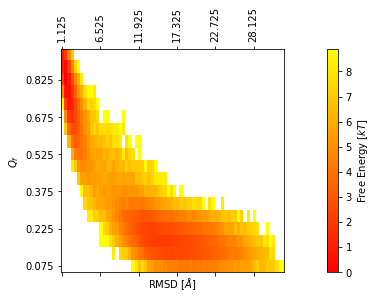

In [20]:
#Create lists to store the calculated values.
RMSD = []
Qf = []

#Read the PyWham free energy output file
with open('pywham_Qf_RMSD_free_energy_T136.0', 'r') as hcf:
    
    #Save all lines into a variable to be read more than once
    lines = hcf.readlines()
    
    #Iterate over the lines to store the values of Qf and RMSD
    for line in lines:
        ls = line.strip().split()
        Qf.append(float(ls[0]))
        RMSD.append(float(ls[1]))

    #Create list of sets of the coordinates to extract only unique values orderly
    Qf_values = sorted(list(set(Qf)))
    RMSD_values = sorted(list(set(RMSD)))
    
    #Count the number of different values for each coordinate
    n_RMSD_values = len(RMSD_values)
    n_Qf_values = len(Qf_values)
    
    #Create a matrix to store the free energy values
    free_energy = np.zeros((n_Qf_values,n_RMSD_values)) #Here the shape of the matrix corresponds to the number of unique values in each coordinate set.
    
    #Fill matrix with nan to show missing values with a different color
    free_energy[:] = np.nan
    
    #Iterate again over the lines to get the indexes where to store the free energy values
    for line in lines:
        ls = line.strip().split()
        i = Qf_values.index(float(ls[0]))    #Matrix index for Qf coordinate
        j = RMSD_values.index(float(ls[1]))  #Matrix index for RMSD coordinate
        free_energy[i,j] = float(ls[2])

    #Set the lower minimum of the free energy profile to zero
    free_energy = free_energy- np.nanmin(free_energy)  #Special numpy minimum function that ignores nan

#Plot the free energy matrix
aspect_ratio = n_RMSD_values/n_Qf_values                                #Define an aspect ration to have a square plot
plt.matshow(free_energy, cmap=plt.cm.autumn, aspect=aspect_ratio)       #Plot the matrix using the 'autumn' color map
plt.gca().invert_yaxis()                                                #Invert the Y axis to show the origin near the bottom left
plt.xlabel('RMSD [$\AA$]')                                              #Add the x coordinate label
plt.ylabel('$Q_f$')                                                     #Add the y coordinate label
plt.xticks(range(n_RMSD_values)[::12], RMSD_values[::12], rotation=90)  #Add labels for x coordinate
plt.yticks(range(n_Qf_values)[::3], Qf_values[::3])                     #Add labels for y coordinate
plt.colorbar(label='Free Energy [$kT$]')                                #Add the z coordinate label

We see that the free energy profile contains two minima in a diagonal fashion. Again, at least regarding the simulation carried out, we confirm the idea that the folding simulation occurs in single step for this system.

Another, more elegant, way to see the data in our free energy matrix is to use a contour plot. Using the same data as before we plot black contour lines black over a color filled contour plot:

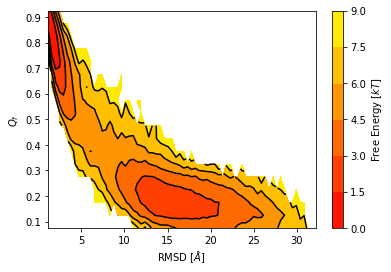

In [49]:
#Plot the free energy matrix
plt.contour(RMSD_values,Qf_values, free_energy,  colors='black')  
plt.contourf(RMSD_values,Qf_values, free_energy,  cmap='autumn') #Note the use of the contourf funtion here.
plt.xlabel('RMSD [$\AA$]')
plt.ylabel('$Q_f$')
plt.colorbar(label='Free Energy [$kT$]')

### Summary

In this tutorial we calculated two reaction coordinates for the simulation: the RMSD relative to the folded structure and the fraction of native contacts $Q_f$. We then used PyWham program to derive free energy profiles of the simulated data, projecting the potential energy values into each one of these coordinates, using the [WHAM](https://onlinelibrary.wiley.com/doi/abs/10.1002/jcc.540130812) method. We also used an interpolation technique to improve the visualization of the profile's data. Finally, we derived a bi-dimensional free energy profile using both, the RMSD and the $Q_f$, coordinates. This was plotted using a matrix coloring scheme and a contour plot which accomplished better looking results. 